In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import h5py

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
F.l1_loss

<function torch.nn.functional.l1_loss(input, target, size_average=None, reduce=None, reduction='mean')>

In [5]:
from uatu.scattering import *
from kymatio import Scattering2D

In [6]:
model_path = '/home/sean/Git/uatu/networks/gupta_net_smooth_0_epoch_33.pth'
#model_path = '/home/sean/Git/uatu/networks/scattering_resnet_max_mode_2.pth'

In [7]:
#mode = 2
mode = 0
#max_order = 2
max_order = 0

#J = 2
J = 0
L = 8
K = int(1 + L*J +(L**2)*(J*(J-1))/2.0)

width = 2
smooth = 0
shape = (256, 256)

In [8]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

In [9]:
#scattering = Scattering2D(J=J, shape=shape, max_order=max_order)
#if use_cuda:
#    scattering = scattering.cuda()

In [10]:
scattering = lambda x:x

In [11]:
model = GuptaNet(1).to(device)

In [12]:
model.load_state_dict(torch.load(model_path, map_location='cpu'))

<All keys matched successfully>

In [13]:
model.eval()

GuptaNet(
  (layer_0): BasicBlock(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): LeakyReLU(negative_slope=0.01, inplace=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (downsample): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (layer_1): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): LeakyReLU(negative_slope=0.01, inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (downsample): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (layer_2): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): LeakyReLU(negative_slope=0.01, inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (downsample): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (relu): LeakyReLU(negative_slope=0.01, inplace=True)
  (fc

In [14]:
def log_barrier(x_p, x_o, eps=2.5, lam=1e9):
    # TODO, in pytorch
    norm = (x_p - x_o).norm() + 1e-6
    return -torch.log(eps - norm )/lam

In [15]:
def fgsm_attack(image, eps, data_grad):
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image - eps*sign_data_grad
    # Adding clipping to maintain [0,1] range
    #perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [16]:
def compute_attacked_map(model, cost_fn, data, target, scattering = lambda x:x): #use_log_barrier = True, log_eps = 1.5)

    # Send the data and label to the device
    data, target = data.to(device), target.to(device)
    # Set requires_grad attribute of tensor. Important for Attack
    perturbed_data = data.clone()

    perturbed_data.requires_grad = True
    #scattering.requires_grad = False
    # Forward pass the data through the model
    init_pred = model(scattering(perturbed_data))
    # TODO put this in a loop with the log barrier
    # Calculate the loss
    output = init_pred.clone()
    for i in range(1):
        loss = cost_fn(output, target)  + log_barrier(data, perturbed_data)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward(retain_graph = True)

        # Collect datagrad
        data_grad = perturbed_data.grad.data

        # Call FGSM Attack
        epsilon = 1e-3
        
        perturbed_data = fgsm_attack(perturbed_data, epsilon, data_grad)
        perturbed_data = torch.autograd.Variable(perturbed_data.data, requires_grad=True)

        # Re-classify the perturbed image
        output = model(scattering(perturbed_data))

    return perturbed_data, init_pred, output

In [17]:
f = h5py.File('../data/UatuLightconeTraining.hdf5', 'r')
mean, std =  f.attrs['mean'], f.attrs['std']
f.close()

In [18]:
f = h5py.File('../data/UatuLightconeSameSeed.hdf5', 'r')
#for boxno in xrange(5):
boxno = 2
target_boxno = 3
test_X = np.array(f['Box%03d'%boxno]["X"][()])
test_Y = f['Box%03d'%boxno]['Y'][0].reshape((1,2))

target_X = np.array(f['Box%03d'%target_boxno]["X"][()])
target_Y = f['Box%03d'%target_boxno]['Y'][0].reshape((1,2))
f.close()

In [19]:
test_X = (test_X-mean)/(std)
target_X = (target_X-mean)/(std)

In [20]:
n = 201 #100 
batch_size = 1 

X = test_X[n, :, :, :].reshape((1, test_X.shape[1],\
                                test_X.shape[2], test_X.shape[3]))
#X = (X-mean)/(std)
X = np.tile(X, (batch_size, 1, 1, 1) )
Y = test_Y[0, :].reshape((1, test_Y.shape[1]))
Y = np.tile(Y, (batch_size, 1))

In [21]:
targ_X = target_X[n, :, :, :].reshape((1, test_X.shape[1],\
                                test_X.shape[2], test_X.shape[3]))
#targ_X = (targ_X-mean)/(std)

In [22]:
import torch.nn.functional as F

In [23]:
X_attacked, init_pred, attacked_pred = compute_attacked_map(model, F.l1_loss,\
                                  torch.Tensor(X).reshape((1, shape[0], shape[1])), \
                                torch.Tensor(target_Y).reshape((1, -1)) )#,\

In [24]:
target_Y

array([[0.350059, 0.946085]])

In [25]:
init_pred.to('cpu').detach().numpy(), attacked_pred.to('cpu').detach().numpy()

(array([[0.22207278, 0.57796675]], dtype=float32),
 array([[0.26155373, 0.6514644 ]], dtype=float32))

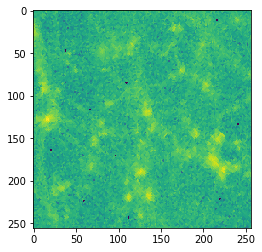

In [26]:
plt.imshow(X[0,:,:,0])

In [27]:
X_attacked = X_attacked.to('cpu').detach().numpy()

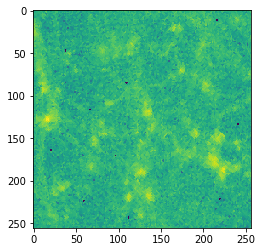

In [28]:
plt.imshow(X_attacked.squeeze())

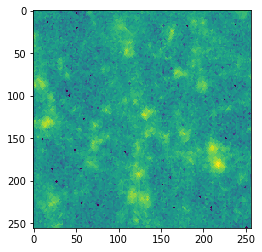

In [29]:
plt.imshow(targ_X[0,:,:,0])

In [30]:
s_orig = scattering(torch.Tensor(X.squeeze()).to('cuda'))

In [31]:
s_attacked = scattering(torch.Tensor(X_attacked.squeeze()).to('cuda'))

In [32]:
s_target = scattering(torch.Tensor(targ_X.squeeze()).to('cuda'))

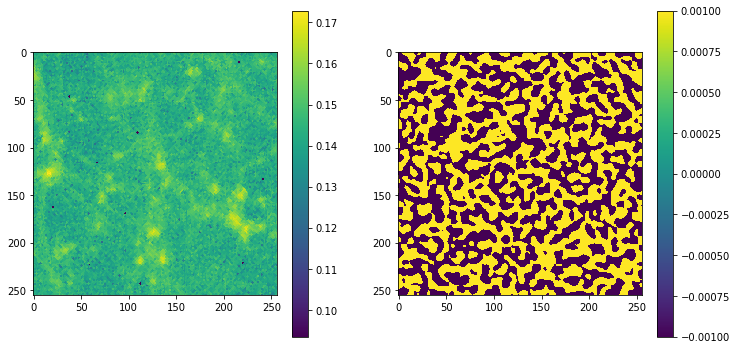

In [33]:
diff = X[0,:,:,0] - X_attacked[0,:,:]
fig = plt.figure(figsize = (12, 6))
plt.subplot(121)
im = plt.imshow(X.squeeze())
plt.colorbar(im)
plt.subplot(122)
im = plt.imshow(-diff)
plt.colorbar(im)

In [34]:
np.linalg.norm(-diff)

0.2560005227002386

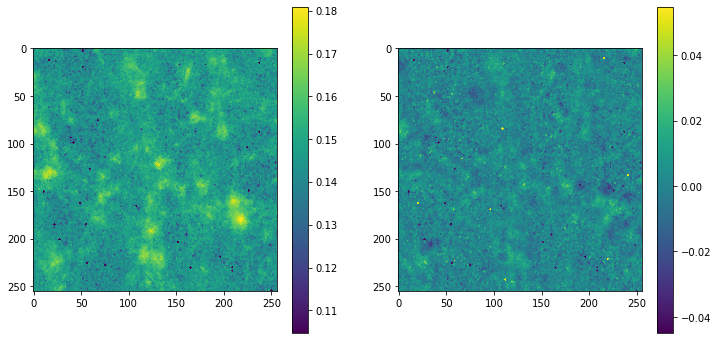

In [35]:
diff = targ_X[0,:,:,0] - X[0,:,:,0]
fig = plt.figure(figsize = (12, 6))
plt.subplot(121)
im = plt.imshow(targ_X[0,:,:,0].squeeze())
plt.colorbar(im)
plt.subplot(122)
im = plt.imshow(diff)
plt.colorbar(im)

In [36]:
np.linalg.norm(diff)

1.8552913465827403

---

In [37]:
from scipy.fftpack import fft2

In [38]:
def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (x.max()-x.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof

In [39]:
from scipy import fftpack
import numpy as np
import pylab as py
#import radialProfile

def image_ps(image):
  
    # Take the fourier transform of the image.
    F1 = fftpack.fft2(image)

    # Now shift the quadrants around so that low spatial frequencies are in
    # the center of the 2D fourier transformed image.
    F2 = fftpack.fftshift( F1 )

    # Calculate a 2D power spectrum
    psd2D = np.abs( F2 )**2

    # Calculate the azimuthally averaged 1D power spectrum
    psd1D = azimuthalAverage(psd2D)

    return psd1D

In [40]:
X_attacked.shape, X.shape

((1, 256, 256), (1, 256, 256, 1))

In [41]:
attacked_ps = image_ps(X_attacked.squeeze())
target_ps = image_ps(targ_X.squeeze())
normal_ps = image_ps(X.squeeze())
diff_ps = image_ps((X_attacked- X[:,:,:,0]).squeeze())

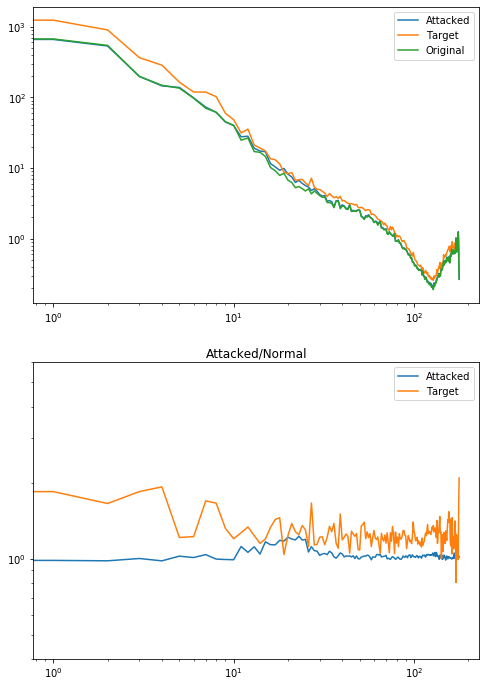

In [42]:
fig = plt.figure(figsize = (8, 12))
plt.subplot(211)
plt.plot(attacked_ps, label = 'Attacked' )
plt.plot(target_ps, label = 'Target')
plt.plot(normal_ps, label = 'Original')
#plt.plot(diff_ps, label = 'Diff')

plt.legend(loc='best')
plt.loglog();
plt.subplot(212)
plt.title("Attacked/Normal")
plt.plot(attacked_ps/normal_ps, label = 'Attacked')
plt.plot(target_ps/normal_ps, label = 'Target')
plt.legend(loc='best')
plt.ylim([0.4, 6])
plt.loglog();

In [43]:
attacked_ps.shape

(179,)